In [1]:
import matplotlib.pyplot as plt
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Descriptors import ExactMolWt
import math

In [2]:
import pandas as pd
import numpy as np

In [3]:
#formose_df = pd.read_csv("39_Formose reaction_MeOH.csv")#39_Formose reaction_MeOH.csv
wet_dextrose = pd.read_csv('dextrose_wet_impcols.csv')
dry_dextrose = pd.read_csv('glucose_dry_impcols.csv')
print(wet_dextrose.columns)

Index(['Peak Number', 'Mass', 'Rel. Abundance', 'Kendrick Mass', 'Nom. Mass',
       'KMD', 'Molecular Formula'],
      dtype='object')


In [16]:
def clean_df(df):# first get rid of empty lines in the mass list by replacing '' with np.nan and dropping rows with nans
    df.replace('', np.nan, inplace=True)
    # also, some 'Mass' values are not numbers
    df.dropna(subset=['Mass'], inplace=True)
    # now replace NaNs with '' to avoid weird errors
    df.fillna('', inplace=True)
    df.shape
    df.head()


In [17]:
clean_df(wet_dextrose)
clean_df(dry_dextrose)
wet_dextrose.head()

,Peak Number,Mass,Rel. Abundance,Kendrick Mass,Nom. Mass,KMD,Molecular Formula
0,1,296.10679,7.4044,295.7762,296.0,224.0,No Hit
1,2,514.28440,3.1185,513.7102,514.0,290.0,
2,3,360.12282,1.9340,359.7207,360.0,279.0,No Hit
3,4,444.14395,0.0246,443.6480,444.0,352.0,No Hit
4,5,458.15959,1.5455,457.6480,458.0,352.0,No Hit


The "No Hit" peaks need to be filtered out.

In [18]:
network_output_file = '../main/glucose/glucose_degradation_output_10mar.txt'#"../main/formose/formose_output.txt"

It turns out that all weights below MW < 160 had no hit for a molecular formula by the spectrometer.

Now check for any peaks in the spectrum that match our model

## False cleansing
There might be entries in the unprocessed spectrum that has assigned values of "No Hit" for the Molecular Formula but they match as C13 containing peaks with our model(s) within 4 decimal places. These could have been missed out by the spectrometer by accident

In [19]:
'''print('Checking dry')
check_mass_matches(dry_dextrose, unique_computed)
print('Total matches = ', count_total_matches(dry_dextrose))
print('Checking wet sample')
check_mass_matches(wet_dextrose, unique_computed)
print('Total matches = ', count_total_matches(wet_dextrose))'''

"print('Checking dry')\ncheck_mass_matches(dry_dextrose, unique_computed)\nprint('Total matches = ', count_total_matches(dry_dextrose))\nprint('Checking wet sample')\ncheck_mass_matches(wet_dextrose, unique_computed)\nprint('Total matches = ', count_total_matches(wet_dextrose))"

In [20]:
def clean_data(df):
    #df.reset_index(inplace=True) # not resetting indices was causing trouble
    cleaned_df = pd.DataFrame(data=[], columns=df.columns)
    for i in range(len(df)):
        if "No Hit" in df['Molecular Formula'].iloc[i]:
            if not np.isnan(df['Matched Gen'].iloc[i]):
                cleaned_df = cleaned_df.append(df.iloc[i])
            else:
                pass
        else:
            cleaned_df = cleaned_df.append(df.iloc[i])
    # keep only m/z < 200, because we don't have higher peaks to compare
    cleaned_df = cleaned_df[cleaned_df['Mass'] < 200.0]
    # now, "renormalize" the relative abundance.
    highest = max(cleaned_df['Rel. Abundance'])#max(rel_abundance)
    norm_factor = 100.0/highest
    cleaned_df['Norm Abun'] = cleaned_df['Rel. Abundance']*norm_factor
    
    print(f"{len(cleaned_df)} items in the given dataframe")
    return cleaned_df

In [23]:
proton_mass = 1.007276
c13_correction = 1.003355

def get_computed_masses(smiles_list):
    mass_list = []
    for smiles in smiles_list:
        mol = MolFromSmiles(smiles)
        mass_list.append(ExactMolWt(mol))
    return mass_list


def check_mass_matches(exp, computed):
    matches_found = []
    c13_containing = []
    for peak in exp['Mass']: # the 'Mass' is actually m/z
        # if any peak (after accounting for the mass of a proton due to ESI) matches a computed value within
        # 4 decimal places, we claim a match.
        gen_matched = np.nan 
        has_c13 = False
        for i in range(len(computed)):
            if abs((peak+proton_mass) - computed['Exact Mass'].iloc[i]) <= 0.0001:
                gen_matched = computed['Generation'].iloc[i]
                break
            elif abs((peak+proton_mass) - (computed['Exact Mass'].iloc[i] + c13_correction)) <= 0.0001:
                gen_matched = computed['Generation'].iloc[i]
                print(f'Peak at m/z {peak} may have a C13 isotope! Found in gen {gen_matched},'
                      + f" it matches  with {computed['Exact Mass'].iloc[i]}")
                has_c13 = True
                break
            else:
                gen_matched = np.nan
        matches_found.append(gen_matched)
        c13_containing.append(has_c13)
        #print(f'Peak: {peak} matched in {gen_matched}')
    exp['Matched Gen'] = matches_found
    exp['Has C13'] = c13_containing


def mz_to_mass(df):
    # add proton mass to convert m/z to exact mass
    df['Corr Mass'] = df['Mass'] + proton_mass

def count_total_matches(df):
    df_clean = df.dropna(subset=['Matched Gen'])
    return sum([True for matched_gen in df_clean['Matched Gen'] if matched_gen is not np.nan])

computed_network = pd.read_csv(network_output_file, sep='\t', names=['Generation', 'SMILES'])

# change 'Generation' entries to integers n instead of 'Gn'
computed_network['Generation'] = pd.DataFrame(int(computed_network['Generation'].iloc[i][1])
                                                  for i in range(len(computed_network)))
computed_network['Exact Mass'] = get_computed_masses(computed_network['SMILES'])

# The computing time can be reduced easily by 2 orders of magnitude if I get rid of redundant
# entries with identical mass (but different structure) in the computed spectrum df.
# So that's what I will do below.
unique_computed = computed_network.drop_duplicates(['Exact Mass'], keep='first')

#  Check for matches with experimental spec
check_mass_matches(wet_dextrose, unique_computed)
print('Matches in cleaned wet sample: ', count_total_matches(wet_dextrose))
check_mass_matches(dry_dextrose, unique_computed)
print('Matches in cleaned dry sample: ', count_total_matches(dry_dextrose))

mz_to_mass(wet_dextrose)
mz_to_mass(dry_dextrose)

# see what the differences look like
wet_dextrose.head()
#computed_network.head()

Peak at m/z 180.05948 may have a C13 isotope! Found in gen 0, it matches  with 180.063388104
Peak at m/z 196.05438 may have a C13 isotope! Found in gen 1, it matches  with 196.05830272400001
Matches in cleaned wet sample:  21
Peak at m/z 180.05948999999998 may have a C13 isotope! Found in gen 0, it matches  with 180.063388104
Peak at m/z 196.0544 may have a C13 isotope! Found in gen 1, it matches  with 196.05830272400001
Matches in cleaned dry sample:  20


,Peak Number,Mass,Rel. Abundance,Kendrick Mass,Nom. Mass,KMD,Molecular Formula,Matched Gen,Has C13,Corr Mass
0,1,296.10679,7.4044,295.7762,296.0,224.0,No Hit,NaN,False,297.114066
1,2,514.28440,3.1185,513.7102,514.0,290.0,,NaN,False,515.291676
2,3,360.12282,1.9340,359.7207,360.0,279.0,No Hit,NaN,False,361.130096
3,4,444.14395,0.0246,443.6480,444.0,352.0,No Hit,NaN,False,445.151226
4,5,458.15959,1.5455,457.6480,458.0,352.0,No Hit,NaN,False,459.166866


In [25]:
cleaned_wet_dex = clean_data(wet_dextrose)
cleaned_dry_dex = clean_data(dry_dextrose)
cleaned_wet_dex

34 items in the given dataframe
34 items in the given dataframe


,Peak Number,Mass,Rel. Abundance,Kendrick Mass,Nom. Mass,KMD,Molecular Formula,Matched Gen,Has C13,Corr Mass,Norm Abun
141,142,180.05948,0.1034,179.8584,180.0,142.0,No Hit,0.0,True,181.066756,6.955001
602,603,196.05438,0.0271,195.8355,196.0,165.0,No Hit,1.0,True,197.061656,1.822829
1213,44,195.02990,0.0208,194.8122,195.0,188.0,,5.0,False,196.037176,1.399072
1216,47,179.05612,1.4867,178.8562,179.0,144.0,,0.0,False,180.063396,100.000000
1425,256,189.04047,0.0112,188.8294,189.0,171.0,,3.0,False,190.047746,0.753346
1512,343,195.05103,0.3690,194.8333,195.0,167.0,,1.0,False,196.058306,24.820071
1694,525,193.01425,0.0127,192.7988,193.0,201.0,,NaN,False,194.021526,0.854241
1711,542,179.03499,0.0388,178.8351,179.0,165.0,,5.0,False,180.042266,2.609807
1712,543,193.05064,0.0496,192.8351,193.0,165.0,,NaN,False,194.057916,3.336248
1719,550,183.02990,0.0108,182.8256,183.0,174.0,,4.0,False,184.037176,0.726441


In [26]:
print(sum([True for status in cleaned_dry_dex['Has C13'] if status == True]))

2


I see that $^{12}$C matches didn't get missed out even before

In [28]:
import seaborn as sns

def plot_spec(df, file_name='mass_spectrum.jpg'):
    fig, ax = plt.subplots(figsize=(6,6)) # create a figure object
    # first, draw the experimental spectrum lines
    #plt.vlines(x=df['Mass'], ymin=0, ymax=df['Norm Abun'], color='gray')
    plt.bar(df['Corr Mass'], df['Norm Abun'], color='gray', width=0.2)
    plt.yscale('log')
    #plt.ylim([0.875, 125])
    df_matched = df.dropna()
    df_matched['Matched Gen'] = df_matched['Matched Gen'].astype(int)#['G' + str(round(df_matched['Matched Gen'].iloc[i]))
                                 #for i in range(len(df_matched))]
    #cols = ['crimson', 'darkorange', 'gold', 'g', 'royalblue', '#CA38FF']#'violet']
    #cols = ['dimgray', 'crimson', 'olive', 'steelblue', 'cornflowerblue', 'deeppink']
    splot = sns.scatterplot(data=df_matched,
                    x='Corr Mass',
                    y='Norm Abun', 
                    style='Has C13',
                    markers=['o', 'D'],
                    hue='Matched Gen', 
                    palette='Spectral',#cols,
                    linewidth=0.3,
                    s=64,
                    ec='k',
                    zorder=2,
                    legend='full')
    ax.minorticks_on()
    #for h in splot.legend_.legendHandles: 
    #    h.set_marker('x')
    ax.tick_params(axis='both', labelsize=13)
    plt.xlabel('Exact Mass', fontsize=13)
    plt.ylabel('Relative Abundance', fontsize=13)
    
    h, l = splot.get_legend_handles_labels()
    splot.legend(handles=h[1:7], labels=l[1:7], #labels=[f'G{i}' for i in range(6)],
                 title='Matched in', #fontsize=14)
    #splot.legend(handles=h[8:10], labels=['$^{12}$C', '$^{13}$C'], title='Isotope',
                 fontsize=13, title_fontsize=13, markerscale=1.2,
                 loc='upper left', handletextpad=0.1)
    #labs = [f'G{i}' for i in l]
    #print(labs)
    print(l)
    '''from matplotlib.lines import Line2D
    hans = [Line2D([0], [0], marker='x', ls='', color=cols[n], label=f'G{n}') for n in range(6)]
                        #markerfacecolor='g', markersize=15))]'''
    #splot.legend(loc='upper left', handles=h, labels=labs, title='Matched in', fontsize=13, title_fontsize=13,
    #            markerscale=1.2)
    
    plt.tight_layout()
    plt.savefig(file_name, dpi=300)
    plt.show()

## Plotting!
Whew

/home/aayush/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


['Matched Gen', '0', '1', '2', '3', '4', '5', 'Has C13', 'False', 'True']


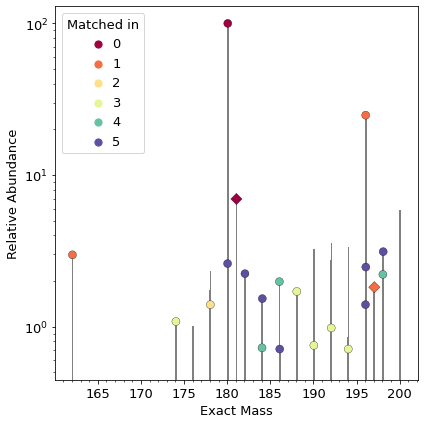

In [29]:
plot_spec(cleaned_wet_dex, 'wet_dextrose_ms.jpg')

/home/aayush/miniconda3/envs/my-rdkit-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


['Matched Gen', '0', '1', '2', '3', '4', '5', 'Has C13', 'False', 'True']


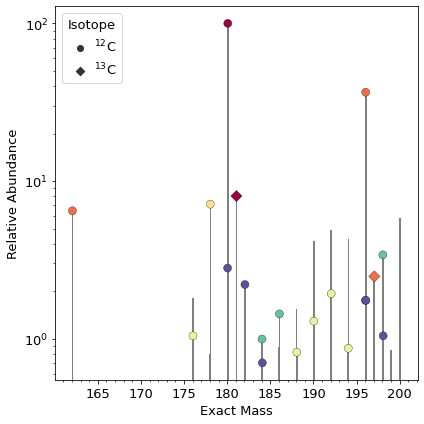

In [179]:
plot_spec(cleaned_dry_dex, 'dry_dextrose_ms.jpg')

Below is legacy code I was using before. You can safely ignore it.

In [ ]:
'''with open(network_output_file) as out:
        lines = out.readlines()
        # a dictionary in which we'll store the smiles string
        # and the generation in which it first appeared
        smiles_gen_dict = {}
        for line in lines:
            line_comps = line.split('\t') #items in the line are separated by a tabspace
            smiles_gen_dict[line_comps[1]] = line_comps[0][1] #2nd character of component 0 is the generation number

        for smiles, gen in smiles_gen_dict.items():
            #print(gen+"--->"+smiles)
            mol = MolFromSmiles(smiles)
            wt = ExactMolWt(mol)
            if wt not in wt_gen_dict:    
                wt_gen_dict[wt]=gen

    

    matching_mass_list = []
    match_gen_list = []
    # check every peak in the exp spectrum
    for obs_mass in df['Mass']:
        for sim_weight, gen in wt_gen_dict.items():
            if abs((sim_weight - proton_mass) - obs_mass) < 0.0001:
                print(f'{obs_mass} got matched in gen {gen}. It corresponds to MW {obs_mass + proton_mass}')
                matching_mass_list.append(obs_mass)
                match_gen_list.append(int(gen))
                break
    # it will be convenient to plot these by generation if I separated them by gen into a map
    round_match_dict = {}
    for i in range(len(match_gen_list)):
        # if this gen id is in the map,
        if match_gen_list[i] in round_match_dict.keys():
            round_match_dict[match_gen_list[i]].append(matching_mass_list[i])
        else:
            # each value corresponding to a gen is supposed to be a list of masses (same as those in exp spectrum)
            round_match_dict[match_gen_list[i]] = [matching_mass_list[i]]

    # we want to color the markers by generation
    colors = ['r', 'c', 'g', 'b', 'm', 'k']
    for gen_app, matches_list in round_match_dict.items():
        # fetch the abundances of each subset of matching peaks
        mass_abuns = []
        for mass in matches_list:
            mass_abuns.append(normalized_abun[mass_list.index(mass)])
        #print(f"Matches list: {matches_list}")
        #print(f"Abundances: {mass_abuns}")
        plt.scatter(matches_list, mass_abuns, marker='x', color=colors[gen_app-2], label=f'Generation {gen_app}')

    # also, check for matches with 13-C isotope peaks. 
    c13_matching_masses = []
    c13_match_gens = []
    # need to add this to get the mass of 13-C carbon
    c13_correction = 1.003355

    # now repeat the above exercise
    # check every peak in the exp spectrum
    for obs_mass in mass_list:
        for sim_weight, gen in wt_gen_dict.items():
            if abs((sim_weight - proton_mass + c13_correction) - obs_mass) < 0.0001:
                print(f'{obs_mass} with 13-C got matched in gen {gen}. It corresponds to MW {obs_mass - c13_correction + proton_mass} w/o C-13')
                c13_matching_masses.append(obs_mass)
                c13_match_gens.append(int(gen))
                break

    c13_gen_match_dict = {}
    for i in range(len(c13_matching_masses)):
        # if this gen id is in the map,
        if c13_match_gens[i] in c13_gen_match_dict.keys():
            c13_gen_match_dict[c13_match_gens[i]].append(c13_matching_masses[i])
        else:
            # each value corresponding to a gen is supposed to be a list of masses (same as those in exp spectrum)
            c13_gen_match_dict[c13_match_gens[i]] = [c13_matching_masses[i]]

    for gen_app, matches_list in c13_gen_match_dict.items():
        # fetch the abundances of each subset of matching peaks
        mass_abuns = []
        for mass in matches_list:
            mass_abuns.append(normalized_abun[mass_list.index(mass)])

        plt.scatter(matches_list, mass_abuns, marker='o', s=20, color=colors[gen_app-2], label=f'Generation {gen_app} ' + '(C$^{13}$)')

    

    #plt.title('Matching peaks in the experimental FT-ICR-MS spectrum of the formose reaction.')
    
    # add a legend
    # make the entries in the legend order by generation in ascending order
    handles, labels = ax.get_legend_handles_labels()
    hl = sorted(zip(handles, labels), key=lambda list: list[1])
    h, l = zip(*hl)
    plt.legend(h, l, loc='upper left', fontsize=12)
'''

In [113]:
#print(f'There are total {len(matching_mass_list) + len(c13_matching_masses)} matches out of {len(mass_list)} total peaks in this range in the mass spectra')

There are total 19 matches out of 32 total peaks in this range in the mass spectra


In [ ]:
# This is old code I was using before. Should be ignored
'''# open the output.txt
weights_dict = {} # a dictionary {weight:generation it first appeared in}

with open("formose_output.txt") as out:
    lines = out.readlines()
    # a dictionary in which we'll store the smiles string
    # and the generation in which it first appeared
    smiles_gen_dict = {}
    for line in lines:
        line_comps = line.split('\t') #items in the line are separated by a tabspace
        smiles_gen_dict[line_comps[1]] = line_comps[0][1] #2nd character of component 0 is the generation number
    
    for smiles, gen in smiles_gen_dict.items():
        #print(gen+"--->"+smiles)
        mol = MolFromSmiles(smiles)
        wt = ExactMolWt(mol)
        if wt not in weights_dict:    
            weights_dict[wt]=gen # This part only see the last matching in generation for a specific mass

espectro = open('formose_ms.csv','r')
lines = espectro.readlines()
#plt.ylim([0, 100])

#obs_mass = [] # list of masses in the glucose.csv
#rel_abundance = [] # rel abundance
match_gen = [] # entry is 0 if not matched, else is set equal generation of first appearance
# check for matches with MOD output
proton_mass = 1.007276
for mass in mass_list:
    found = False
    gen_app = 0
    #print(weights_dict)
    for sim_mass, gen in weights_dict.items():
        if abs((mass + proton_mass) - sim_mass) <= 0.0001:
            found = True
            gen_app=gen
            print(f"{mass} (intensity: {rel_abundance[obs_mass.index(mass)]}) appeared in {gen_app}")
        if found == True:
            match = int(gen_app)
            break
        else:
            match = 0
    match_gen.append(match) 

# Now, mark the matching peaks and color them by generation
# diff color for each generation, add a legend
# to fix issues with legend, I had to make a dictionary for matches by generation

gen_mass_match = {}
for i in range(len(mass_list)):
    if match_gen[i] in gen_mass_match.keys():
        gen_mass_match[match_gen[i]].append(mass_list[i])
    else:
        gen_mass_match[match_gen[i]] = [mass_list[i]]

# Now, place the markers, labelled by generation
colors= ['r','c','g','b','m','k']
for match_gen, mass_list in gen_mass_match.items():
    # I needed the index of the mass in the list obs_mass
    intensities = [rel_abundance[mass_list.index(mass)] for mass in mass_list]
    if match_gen != 0:
        plt.scatter(mass_list, intensities, marker='x', color=colors[match_gen-2], label = f"Generation {match_gen}")
#Glucose info 
mod_glucose_smiles="C(C1C(C(C(C(O)O1)O)O)O)O"
mod_glucose_mass= 180.063388104       
a = mod_glucose_mass - proton_mass
print(f'Calculated mass of glucose: {a}')
        
plt.xlabel("Exact Mass")
plt.ylabel("Relative Abundance")
plt.yscale("log")
#legend should be ordered by generation number
import operator
handles, labels = ax.get_legend_handles_labels()
hl = sorted(zip(handles, labels), key= operator.itemgetter(1))
h,l = zip(*hl)
ax.legend(h, l, loc="upper left")
plt.title("Matching peaks in experimental FT-ICR-MS data for the formose reaction")
plt.savefig("formose_mass_spectra6.jpg", dpi=300, transparent=False)
plt.show()'''

In [114]:
'''# There are values with negative KMD assigned by the spectrometer??
for i in range(len(df['KMD'])):
    if float(df['KMD'].iloc[i]) < 0 and "No Hit" not in df['Molecular Formula'].iloc[i]:
        print(df.iloc[i])'''

Peak Number               27
Mass                 603.852
Rel. Abundance        0.3055
Kendrick Mass        603.178
Nom. Mass                604
KMD                     -178
Molecular Formula           
Name: 26, dtype: object
Peak Number               28
Mass                 678.198
Rel. Abundance        0.2996
Kendrick Mass        677.441
Nom. Mass                678
KMD                     -441
Molecular Formula          *
Name: 27, dtype: object
Peak Number               68
Mass                 562.107
Rel. Abundance        0.0241
Kendrick Mass         561.48
Nom. Mass                562
KMD                     -480
Molecular Formula          *
Name: 67, dtype: object
Peak Number               69
Mass                 576.123
Rel. Abundance         0.153
Kendrick Mass         575.48
Nom. Mass                576
KMD                     -480
Molecular Formula          *
Name: 68, dtype: object
Peak Number               70
Mass                 604.154
Rel. Abundance        0.0137
Kendr

Peak Number             1284
Mass                 681.219
Rel. Abundance         0.017
Kendrick Mass        680.458
Nom. Mass                681
KMD                     -458
Molecular Formula           
Name: 2453, dtype: object
Peak Number             1285
Mass                  589.12
Rel. Abundance        0.0178
Kendrick Mass        588.462
Nom. Mass                589
KMD                     -462
Molecular Formula          *
Name: 2454, dtype: object
Peak Number             1286
Mass                 603.135
Rel. Abundance        0.0288
Kendrick Mass        602.462
Nom. Mass                603
KMD                     -462
Molecular Formula          *
Name: 2455, dtype: object
Peak Number             1287
Mass                 617.151
Rel. Abundance        0.0738
Kendrick Mass        616.462
Nom. Mass                617
KMD                     -462
Molecular Formula          *
Name: 2456, dtype: object
Peak Number             1288
Mass                 645.182
Rel. Abundance        0.03

Peak Number             2053
Mass                 759.157
Rel. Abundance        0.0128
Kendrick Mass        758.309
Nom. Mass                759
KMD                     -309
Molecular Formula          *
Name: 3222, dtype: object
Peak Number             2054
Mass                 773.172
Rel. Abundance        0.0134
Kendrick Mass        772.309
Nom. Mass                773
KMD                     -309
Molecular Formula          *
Name: 3223, dtype: object
Peak Number             2055
Mass                 787.188
Rel. Abundance        0.0199
Kendrick Mass        786.309
Nom. Mass                787
KMD                     -309
Molecular Formula          *
Name: 3224, dtype: object
Peak Number             2056
Mass                 759.214
Rel. Abundance        0.0199
Kendrick Mass        758.366
Nom. Mass                759
KMD                     -366
Molecular Formula          *
Name: 3225, dtype: object
Peak Number             2057
Mass                 713.151
Rel. Abundance        0.01

In [115]:
# What mass does RDKit say, glucose has?
glucose_mol = MolFromSmiles("C(C1C(C(C(C(O)O1)O)O)O)O")
glucose_wt = ExactMolWt(glucose_mol)
print("RDKit calculated glucose weight", glucose_wt)

RDKit calculated glucose weight 180.063388104
